## Climate change analysis (Fossil Fuels Combustion with PM2.5 Focus)


### Author: Zeju Li

### Import packages

In [1]:
#!pip install codecarbon
#!pip install folium

In [2]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score, KFold
from codecarbon import EmissionsTracker
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import folium


### Load the dataset

In [3]:
# Load the Global Weather Repository dataset
weather_data = pd.read_csv('../datasets/GlobalWeatherRepository.csv',encoding='utf-8')
"../datasets/"

# Load the World Data 2023 dataset
world_data = pd.read_csv('../datasets/world-data.csv',encoding='utf-8')

In [4]:
# Display the first few rows to understand their structures
print(weather_data.head())

       country     location_name  latitude  longitude        timezone  \
0  Afghanistan             Kabul     34.52      69.18      Asia/Kabul   
1      Albania            Tirana     41.33      19.82   Europe/Tirane   
2      Algeria           Algiers     36.76       3.05  Africa/Algiers   
3      Andorra  Andorra La Vella     42.50       1.52  Europe/Andorra   
4       Angola            Luanda     -8.84      13.23   Africa/Luanda   

   last_updated_epoch      last_updated  temperature_celsius  \
0          1693301400  2023-08-29 14:00                 28.8   
1          1693301400  2023-08-29 11:30                 27.0   
2          1693301400  2023-08-29 10:30                 28.0   
3          1693301400  2023-08-29 11:30                 10.2   
4          1693301400  2023-08-29 10:30                 25.0   

   temperature_fahrenheit condition_text  ...  air_quality_PM2.5  \
0                    83.8          Sunny  ...                7.9   
1                    80.6  Partly cloudy

In [5]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29434 entries, 0 to 29433
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   country                       29434 non-null  object 
 1   location_name                 29434 non-null  object 
 2   latitude                      29434 non-null  float64
 3   longitude                     29434 non-null  float64
 4   timezone                      29434 non-null  object 
 5   last_updated_epoch            29434 non-null  int64  
 6   last_updated                  29434 non-null  object 
 7   temperature_celsius           29434 non-null  float64
 8   temperature_fahrenheit        29434 non-null  float64
 9   condition_text                29434 non-null  object 
 10  wind_mph                      29434 non-null  float64
 11  wind_kph                      29434 non-null  float64
 12  wind_degree                   29434 non-null  int64  
 13  w

In [6]:
weather_data["country"].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Madagascar', 'Cape Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Comoros',
       'Congo', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Swaziland', 'Ethiopia', 'Fiji Islands', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau

In [7]:
# drop out the indexs that will not be used in analysis
weather_data=weather_data.drop(["air_quality_us-epa-index"],axis=1)
weather_data=weather_data.drop(["air_quality_gb-defra-index"],axis=1)
weather_data=weather_data.drop(["air_quality_PM10"],axis=1)

In [8]:
print(world_data.head())

       Country Density(P/Km2) Abbreviation Agricultural Land( %)  \
0  Afghanistan             60           AF                58.10%   
1      Albania            105           AL                43.10%   
2      Algeria             18           DZ                17.40%   
3      Andorra            164           AD                40.00%   
4       Angola             26           AO                47.50%   

  Land Area(Km2) Armed Forces size  Birth Rate  Calling Code  \
0        652,230           323,000       32.49          93.0   
1         28,748             9,000       11.78         355.0   
2      2,381,741           317,000       24.28         213.0   
3            468               NaN        7.20         376.0   
4      1,246,700           117,000       40.73         244.0   

  Capital/Major City Co2-Emissions  ... Out of pocket health expenditure  \
0              Kabul         8,672  ...                           78.40%   
1             Tirana         4,536  ...               

In [9]:
world_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 35 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Country                                    195 non-null    object 
 1   Density(P/Km2)                             195 non-null    object 
 2   Abbreviation                               188 non-null    object 
 3   Agricultural Land( %)                      188 non-null    object 
 4   Land Area(Km2)                             194 non-null    object 
 5   Armed Forces size                          171 non-null    object 
 6   Birth Rate                                 189 non-null    float64
 7   Calling Code                               194 non-null    float64
 8   Capital/Major City                         192 non-null    object 
 9   Co2-Emissions                              188 non-null    object 
 10  CPI                       

In [10]:
world_data["Country"].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'The Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Ivory Coast',
       'Cape Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Republic of the Congo', 'Costa Rica', 'Croatia',
       'Cuba', 'Cyprus', 'Czech Republic',
       'Democratic Republic of the Congo', 'Denmark', 'Djibouti',
       'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon',
       'The Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada',
       'Guatemal

In [11]:
# drop some columns that are repeated or useless or missing too many values 
world_data=world_data.drop(["Calling Code"],axis=1)
world_data=world_data.drop(["Latitude"],axis=1)
world_data=world_data.drop(["Longitude"],axis=1)
world_data=world_data.drop(["Currency-Code"],axis=1)
world_data=world_data.drop(["Tax revenue (%)"],axis=1)
world_data=world_data.drop(["CPI"],axis=1)
world_data=world_data.drop(["CPI Change (%)"],axis=1)
world_data=world_data.drop(["Co2-Emissions"],axis=1)
world_data=world_data.drop(["Total tax rate"],axis=1)
world_data=world_data.drop(["Armed Forces size"],axis=1)


In [12]:
# Convert PM2.5 to numeric, handling any non-numeric entries
weather_data['air_quality_PM2.5'] = pd.to_numeric(weather_data['air_quality_PM2.5'], errors='coerce')

# Fill missing PM2.5 values with the mean or median, depending on the distribution
weather_data['air_quality_PM2.5'].fillna(weather_data['air_quality_PM2.5'].median(), inplace=True)

In [13]:
# Filling NaN values with 0 
world_data['Population'] = world_data['Population'].str.replace(',', '').fillna(0).astype(int)

# remove the comma
world_data['Density (P/Km2)'] = pd.to_numeric(world_data['Density(P/Km2)'].str.replace(',', ''), errors='coerce')

# Removing '%' from 'Agricultural Land( %)' and converting to float
world_data['Agricultural Land( %)'] = world_data['Agricultural Land( %)'].str.replace('%', '').astype(float) / 100
world_data['Unemployment rate'] = world_data['Unemployment rate'].str.replace('%', '').astype(float).fillna(0) /100
world_data['Population: Labor force participation (%)'] = world_data['Population: Labor force participation (%)'].str.replace('%', '').astype(float).fillna(0) /100

# Removing '$' and converting to float
world_data['Minimum wage'] = world_data['Minimum wage'].str.replace('$', '', regex=False).fillna(0).astype(float)
world_data['Gasoline Price'] = world_data['Gasoline Price'].str.replace('$', '',regex=False).fillna(0).astype(float)


In [14]:
world_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 26 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Country                                    195 non-null    object 
 1   Density(P/Km2)                             195 non-null    object 
 2   Abbreviation                               188 non-null    object 
 3   Agricultural Land( %)                      188 non-null    float64
 4   Land Area(Km2)                             194 non-null    object 
 5   Birth Rate                                 189 non-null    float64
 6   Capital/Major City                         192 non-null    object 
 7   Fertility Rate                             188 non-null    float64
 8   Forested Area (%)                          188 non-null    object 
 9   Gasoline Price                             195 non-null    float64
 10  GDP                       

In [15]:
# checking and mapping the name to make better merge
# Extract unique country names
countries_weather = set(weather_data["country"].unique())
countries_world = set(world_data["Country"].unique())

# Find countries that are not in both DataFrames
only_in_weather = countries_weather - countries_world
only_in_world = countries_world - countries_weather

# Print the results
print("Countries only in weather data:", only_in_weather)
print("Countries only in world data:", only_in_world)


Countries only in weather data: {'Congo', 'Seychelles Islands', 'Macedonia', 'Kyrghyzstan', 'Swaziland', 'Ireland', 'Micronesia', 'United States of America', 'Fiji Islands', 'Gambia', 'Timor-Leste', 'Democratic Republic of Congo', 'Bahamas', 'Brunei Darussalam'}
Countries only in world data: {'Republic of the Congo', 'Laos', 'Eswatini', 'United States', 'Palestinian National Authority', 'The Gambia', 'North Macedonia', 'Brunei', 'Republic of Ireland', 'Federated States of Micronesia', 'Colombia', 'East Timor', 'Libya', 'South Sudan', 'Democratic Republic of the Congo', 'Nauru', 'Fiji', 'Kyrgyzstan', 'Seychelles', 'Moldova', 'Togo', 'S�����������', 'The Bahamas', 'Ivory Coast'}


In [16]:
name_mapping = {
    'Bahamas': 'The Bahamas',
    'Brunei Darussalam': 'Brunei',
    'Congo': 'Republic of the Congo',
    'Democratic Republic of Congo': 'Democratic Republic of the Congo',
    'Fiji Islands': 'Fiji',
    'Gambia': 'The Gambia',
    'Ireland': 'Republic of Ireland',
    'Kyrghyzstan': 'Kyrgyzstan',
    'Macedonia': 'North Macedonia',
    'Micronesia': 'Federated States of Micronesia',
    'Seychelles Islands': 'Seychelles',
    'Swaziland': 'Eswatini',
    'Timor-Leste': 'East Timor',
    'United States of America': 'United States'
}


# replace with correct name
weather_data['country'] = weather_data['country'].replace(name_mapping)

In [17]:
print(set(weather_data['country'].unique()) - set(world_data['Country'].unique()))
print(set(world_data['Country'].unique()) - set(weather_data['country'].unique()))
# some country might not contain in the weather dataset, so we will skip these ones

set()
{'Nauru', 'Laos', 'Moldova', 'Palestinian National Authority', 'Togo', 'S�����������', 'Ivory Coast', 'Colombia', 'Libya', 'South Sudan'}


In [18]:
# Merge datasets on 'country'
weather_data['country'] = weather_data['country'].str.strip().str.lower()
world_data['Country'] = world_data['Country'].str.strip().str.lower()
merged_data = pd.merge(weather_data, world_data, left_on='country', right_on='Country', how='inner')

In [19]:
# drop nan values
merged_data=merged_data.dropna()

In [20]:
#Check first few rows
merged_data.head()

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,Maternal mortality ratio,Minimum wage,Official language,Out of pocket health expenditure,Physicians per thousand,Population,Population: Labor force participation (%),Unemployment rate,Urban_population,Density (P/Km2)
0,afghanistan,Kabul,34.52,69.18,Asia/Kabul,1693301400,2023-08-29 14:00,28.8,83.8,Sunny,...,638.0,0.43,Pashto,78.40%,0.28,38041754,0.489,0.1112,"9,797,273",60
1,afghanistan,Kabul,34.52,69.18,Asia/Kabul,1693364400,2023-08-30 07:30,21.3,70.3,Sunny,...,638.0,0.43,Pashto,78.40%,0.28,38041754,0.489,0.1112,"9,797,273",60
2,afghanistan,Kabul,34.52,69.18,Asia/Kabul,1693439100,2023-08-31 04:15,18.1,64.6,Clear,...,638.0,0.43,Pashto,78.40%,0.28,38041754,0.489,0.1112,"9,797,273",60
3,afghanistan,Kabul,34.52,69.18,Asia/Kabul,1693525500,2023-09-01 04:15,19.2,66.6,Clear,...,638.0,0.43,Pashto,78.40%,0.28,38041754,0.489,0.1112,"9,797,273",60
4,afghanistan,Kabul,34.52,69.18,Asia/Kabul,1693611000,2023-09-02 04:00,18.5,65.3,Moderate rain at times,...,638.0,0.43,Pashto,78.40%,0.28,38041754,0.489,0.1112,"9,797,273",60


In [21]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25671 entries, 0 to 29433
Data columns (total 64 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   country                                    25671 non-null  object 
 1   location_name                              25671 non-null  object 
 2   latitude                                   25671 non-null  float64
 3   longitude                                  25671 non-null  float64
 4   timezone                                   25671 non-null  object 
 5   last_updated_epoch                         25671 non-null  int64  
 6   last_updated                               25671 non-null  object 
 7   temperature_celsius                        25671 non-null  float64
 8   temperature_fahrenheit                     25671 non-null  float64
 9   condition_text                             25671 non-null  object 
 10  wind_mph              

In [22]:
merged_data["country"].unique()

array(['afghanistan', 'albania', 'algeria', 'angola',
       'antigua and barbuda', 'argentina', 'armenia', 'australia',
       'austria', 'azerbaijan', 'the bahamas', 'bahrain', 'bangladesh',
       'barbados', 'belarus', 'belgium', 'belize', 'benin', 'bhutan',
       'botswana', 'brazil', 'bulgaria', 'burkina faso', 'burundi',
       'madagascar', 'cape verde', 'cambodia', 'cameroon', 'canada',
       'central african republic', 'chad', 'chile', 'china', 'comoros',
       'costa rica', 'croatia', 'cyprus', 'czech republic',
       'democratic republic of the congo', 'denmark', 'djibouti',
       'dominican republic', 'ecuador', 'egypt', 'el salvador',
       'equatorial guinea', 'eritrea', 'estonia', 'ethiopia', 'fiji',
       'finland', 'france', 'gabon', 'the gambia', 'georgia', 'germany',
       'ghana', 'greece', 'grenada', 'guatemala', 'guinea',
       'guinea-bissau', 'guyana', 'haiti', 'honduras', 'hungary',
       'iceland', 'india', 'indonesia', 'iran', 'iraq', 'israel', 'it

## EDA


In [23]:
# use subset to make a geographic map for a glance
avg_pm25_and_coords = merged_data.groupby('country')[['air_quality_PM2.5', 'latitude', 'longitude']].mean().reset_index()

In [24]:
import folium

# Create a base map
map = folium.Map(location=[0, 0], zoom_start=2)

# Function to determine color based on PM2.5 levels
def pm25_color(pm25):
    if pm25 > 150:
        return 'red'  # Unhealthy
    elif pm25 > 100:
        return 'orange'  # Unhealthy for Sensitive Groups
    elif pm25 > 50:
        return 'yellow'  # Moderate
    else:
        return 'green'  # Good

# Example DataFrame loading and iteration might look like this:
# Adjust 'avg_pm25_and_coords' DataFrame to include 'country', 'latitude', 'longitude', 'air_quality_PM2.5'
for _, row in avg_pm25_and_coords.iterrows():
    tooltip_content = f"Country: {row['country']}<br>PM2.5: {row['air_quality_PM2.5']:.2f} µg/m³"
    tooltip = folium.Tooltip(tooltip_content)

    folium.Circle(
        location=[row['latitude'], row['longitude']],
        radius=20000,  # Adjust the radius if needed
        color=pm25_color(row['air_quality_PM2.5']),
        fill=True,
        fill_color=pm25_color(row['air_quality_PM2.5']),
        fill_opacity=0.7,
        tooltip=tooltip
    ).add_to(map)

#add a legend for better understanding
legend_html = '''
<div style="position: fixed; 
     bottom: 50px; left: 50px; width: 250px; height: 150px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     padding: 10px 10px;
     background: white;
     ">&nbsp; <b>PM2.5 Levels</b><br>
     &nbsp; <i style="background:green; width: 20px; height: 10px; vertical-align: middle; display: inline-block;"></i>&nbsp;0-50 Good<br>
     &nbsp; <i style="background:yellow; width: 20px; height: 10px; vertical-align: middle; display: inline-block;"></i>&nbsp;51-100 Moderate<br>
     &nbsp; <i style="background:orange; width: 20px; height: 10px; vertical-align: middle; display: inline-block;"></i>&nbsp;101-150 Unhealthy for Sensitive Groups<br>
     &nbsp; <i style="background:red; width: 20px; height: 10px; vertical-align: middle; display: inline-block;"></i>&nbsp;151+ Unhealthy</div>
'''
map.get_root().html.add_child(folium.Element(legend_html))


# Display the map
map.save('../photos/pm25_map.html')
map


In [25]:
# save the map
map.save('../photos/pm25_map.html')

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
# set the resolution
plt.rcParams['figure.dpi']=150

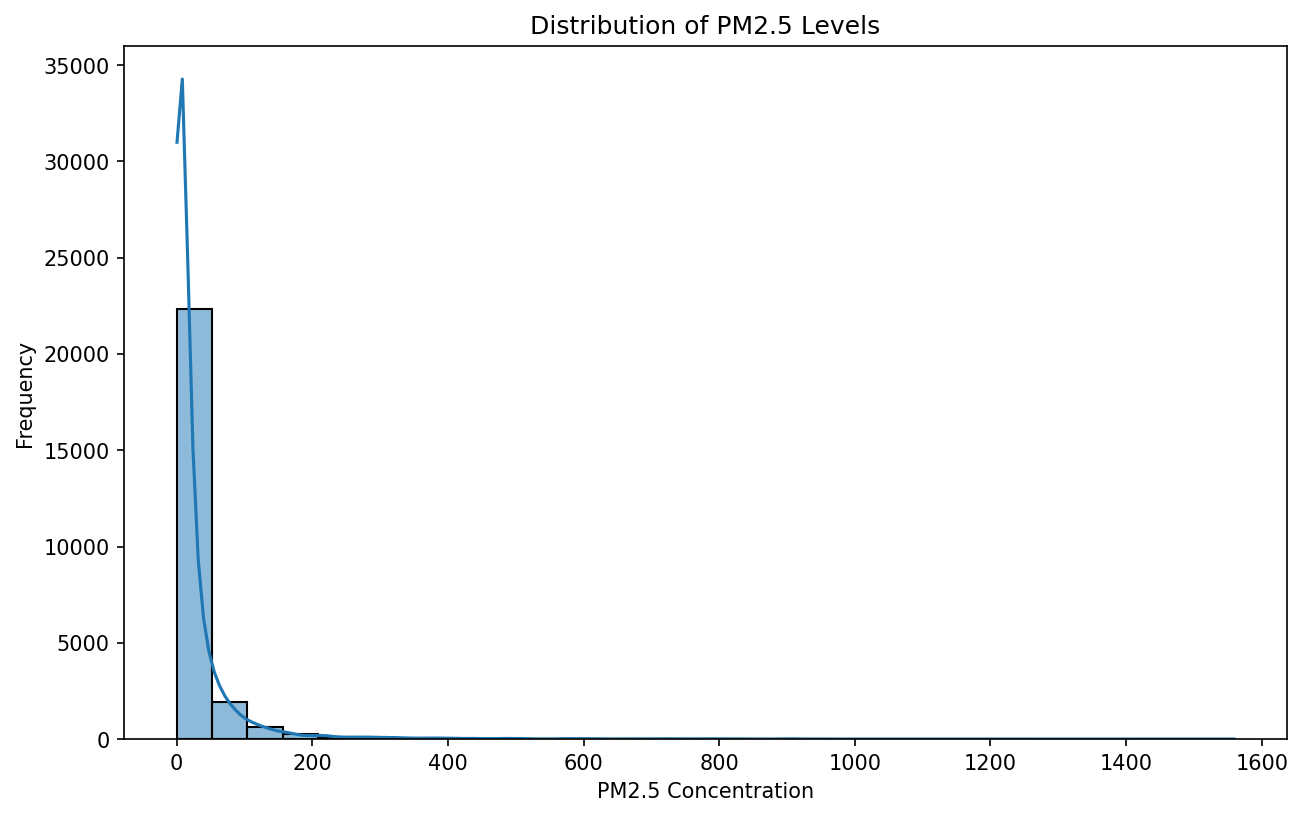

In [27]:
# Visualize the distribution of PM2.5 levels
plt.figure(figsize=(10, 6))
sns.histplot(data=merged_data, x='air_quality_PM2.5', bins=30, kde=True)
plt.title('Distribution of PM2.5 Levels')
plt.xlabel('PM2.5 Concentration')
plt.ylabel('Frequency')
plt.show()


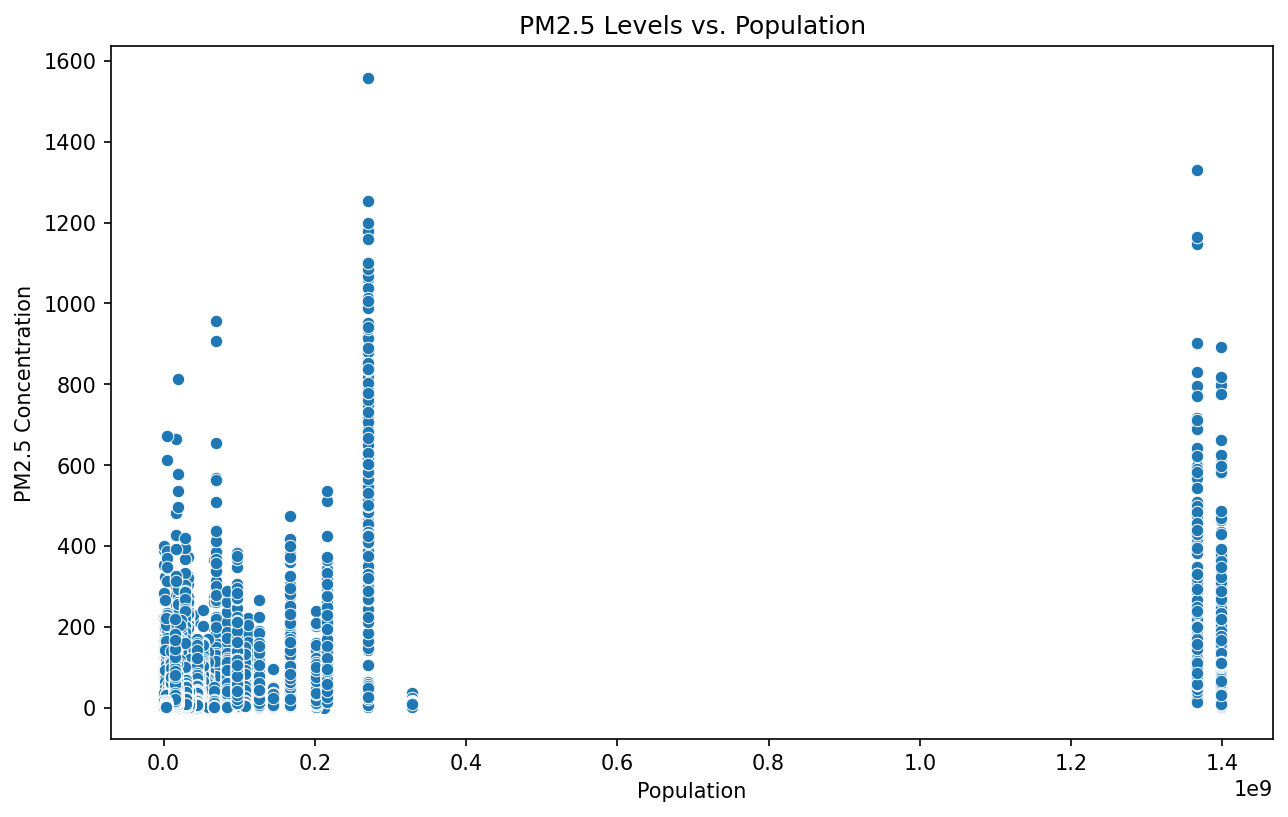

In [28]:
# Scatter plot to explore the relationship between PM2.5 levels and population density
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data, x='Population', y='air_quality_PM2.5')
plt.title('PM2.5 Levels vs. Population')
plt.xlabel('Population')
plt.ylabel('PM2.5 Concentration')
plt.show()

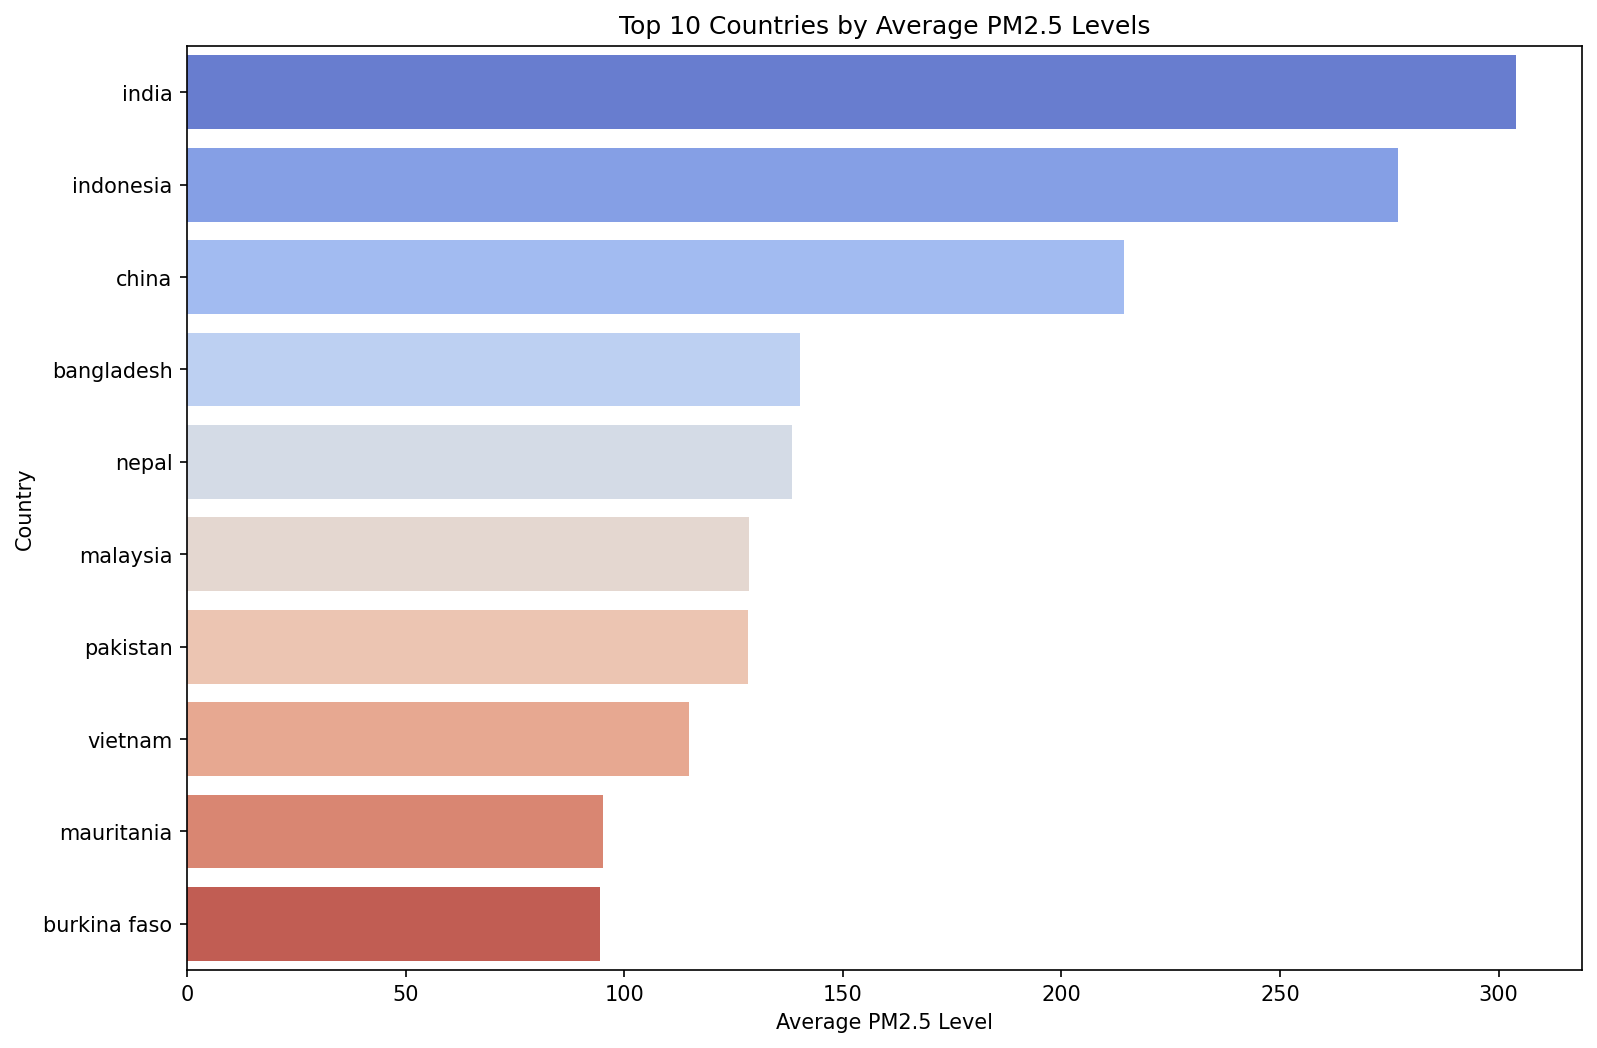

In [29]:
# Group by 'country' and calculate the mean 'air_quality_PM2.5' for each country
average_pm25_by_country = merged_data.groupby('country')['air_quality_PM2.5'].mean()

# Sort the averages in descending order and select the top 10
top_10_pm25_countries = average_pm25_by_country.sort_values(ascending=False).head(10)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x=top_10_pm25_countries.values, y=top_10_pm25_countries.index, palette='coolwarm')
plt.title('Top 10 Countries by Average PM2.5 Levels')
plt.xlabel('Average PM2.5 Level')
plt.ylabel('Country')
plt.show()

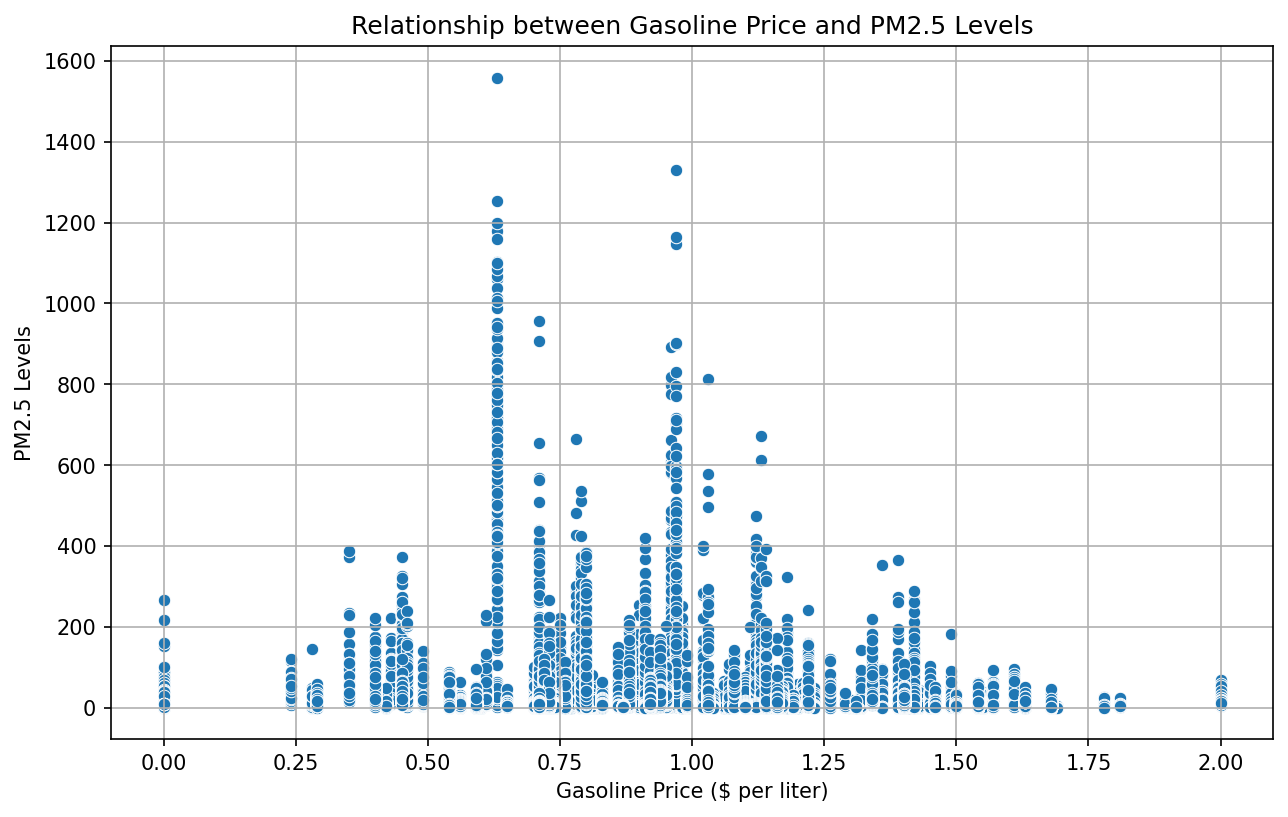

In [30]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data, x='Gasoline Price', y='air_quality_PM2.5')

plt.title('Relationship between Gasoline Price and PM2.5 Levels')
plt.xlabel('Gasoline Price ($ per liter)')
plt.ylabel('PM2.5 Levels')
plt.grid(True)  # Optional: Adds a grid for better readability
plt.show()

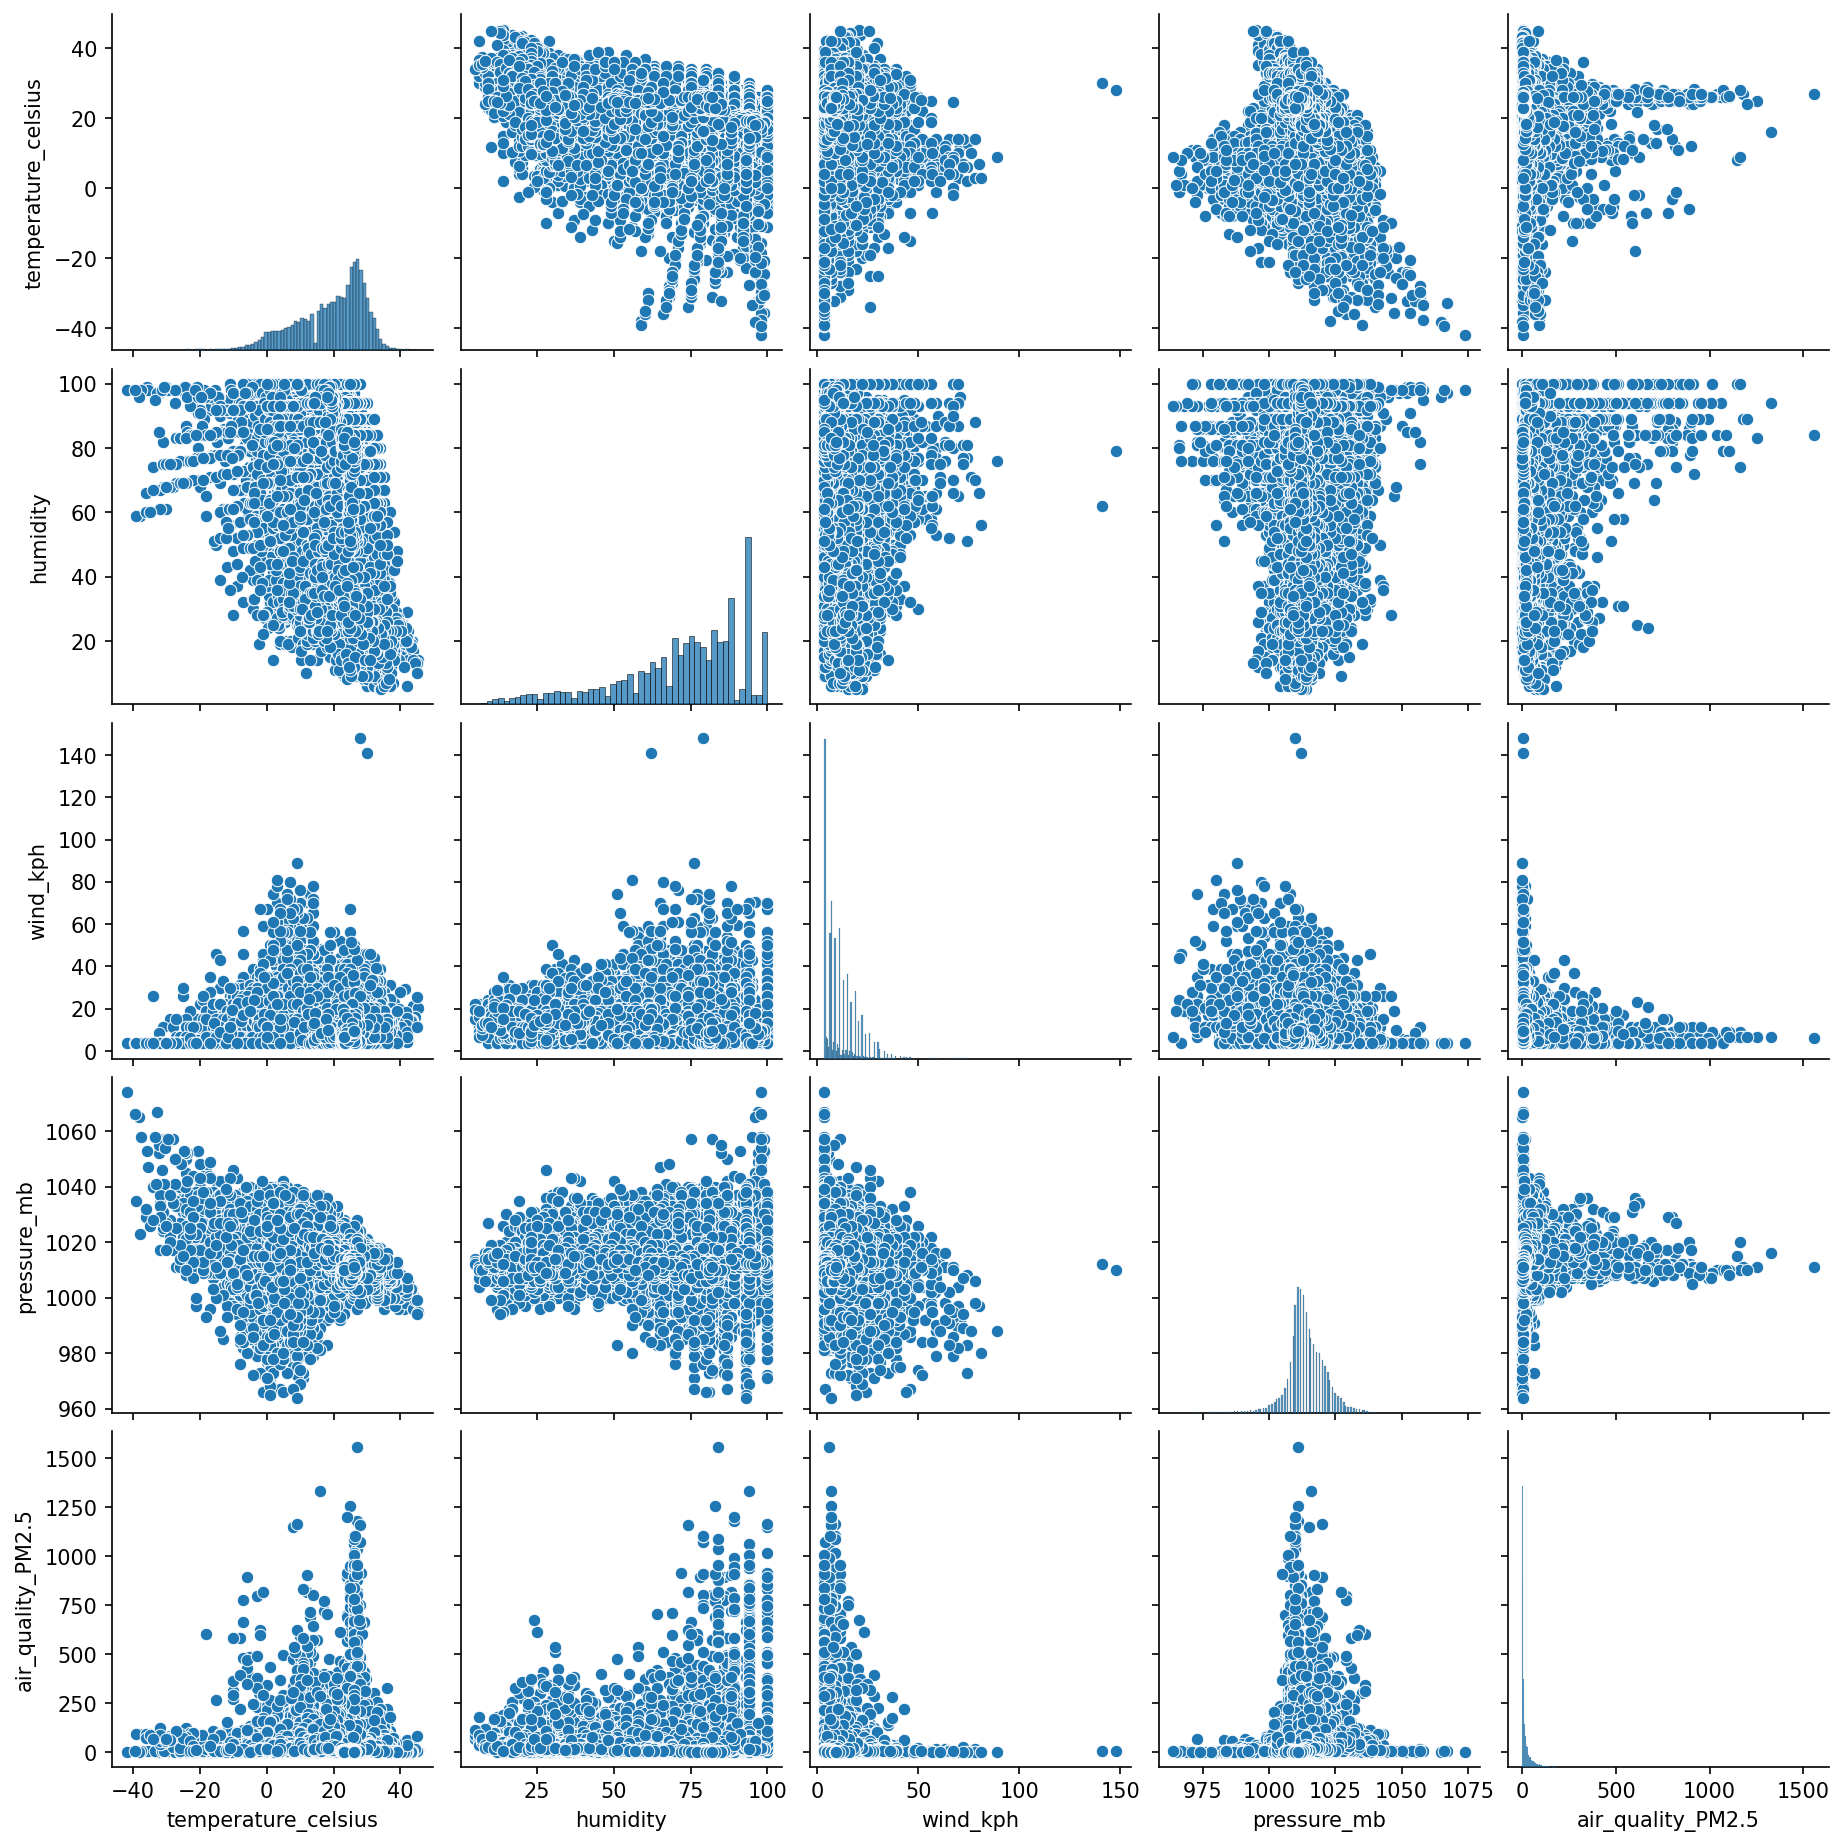

In [31]:
# Selecting a subset of the dataset for the pairplot
variables_for_pairplot = [
    'temperature_celsius',
    'humidity',
    'wind_kph',
    'pressure_mb',
    'air_quality_PM2.5'
]

# Creating the pairplot for the selected variables
sns.pairplot(merged_data[variables_for_pairplot])
plt.show()

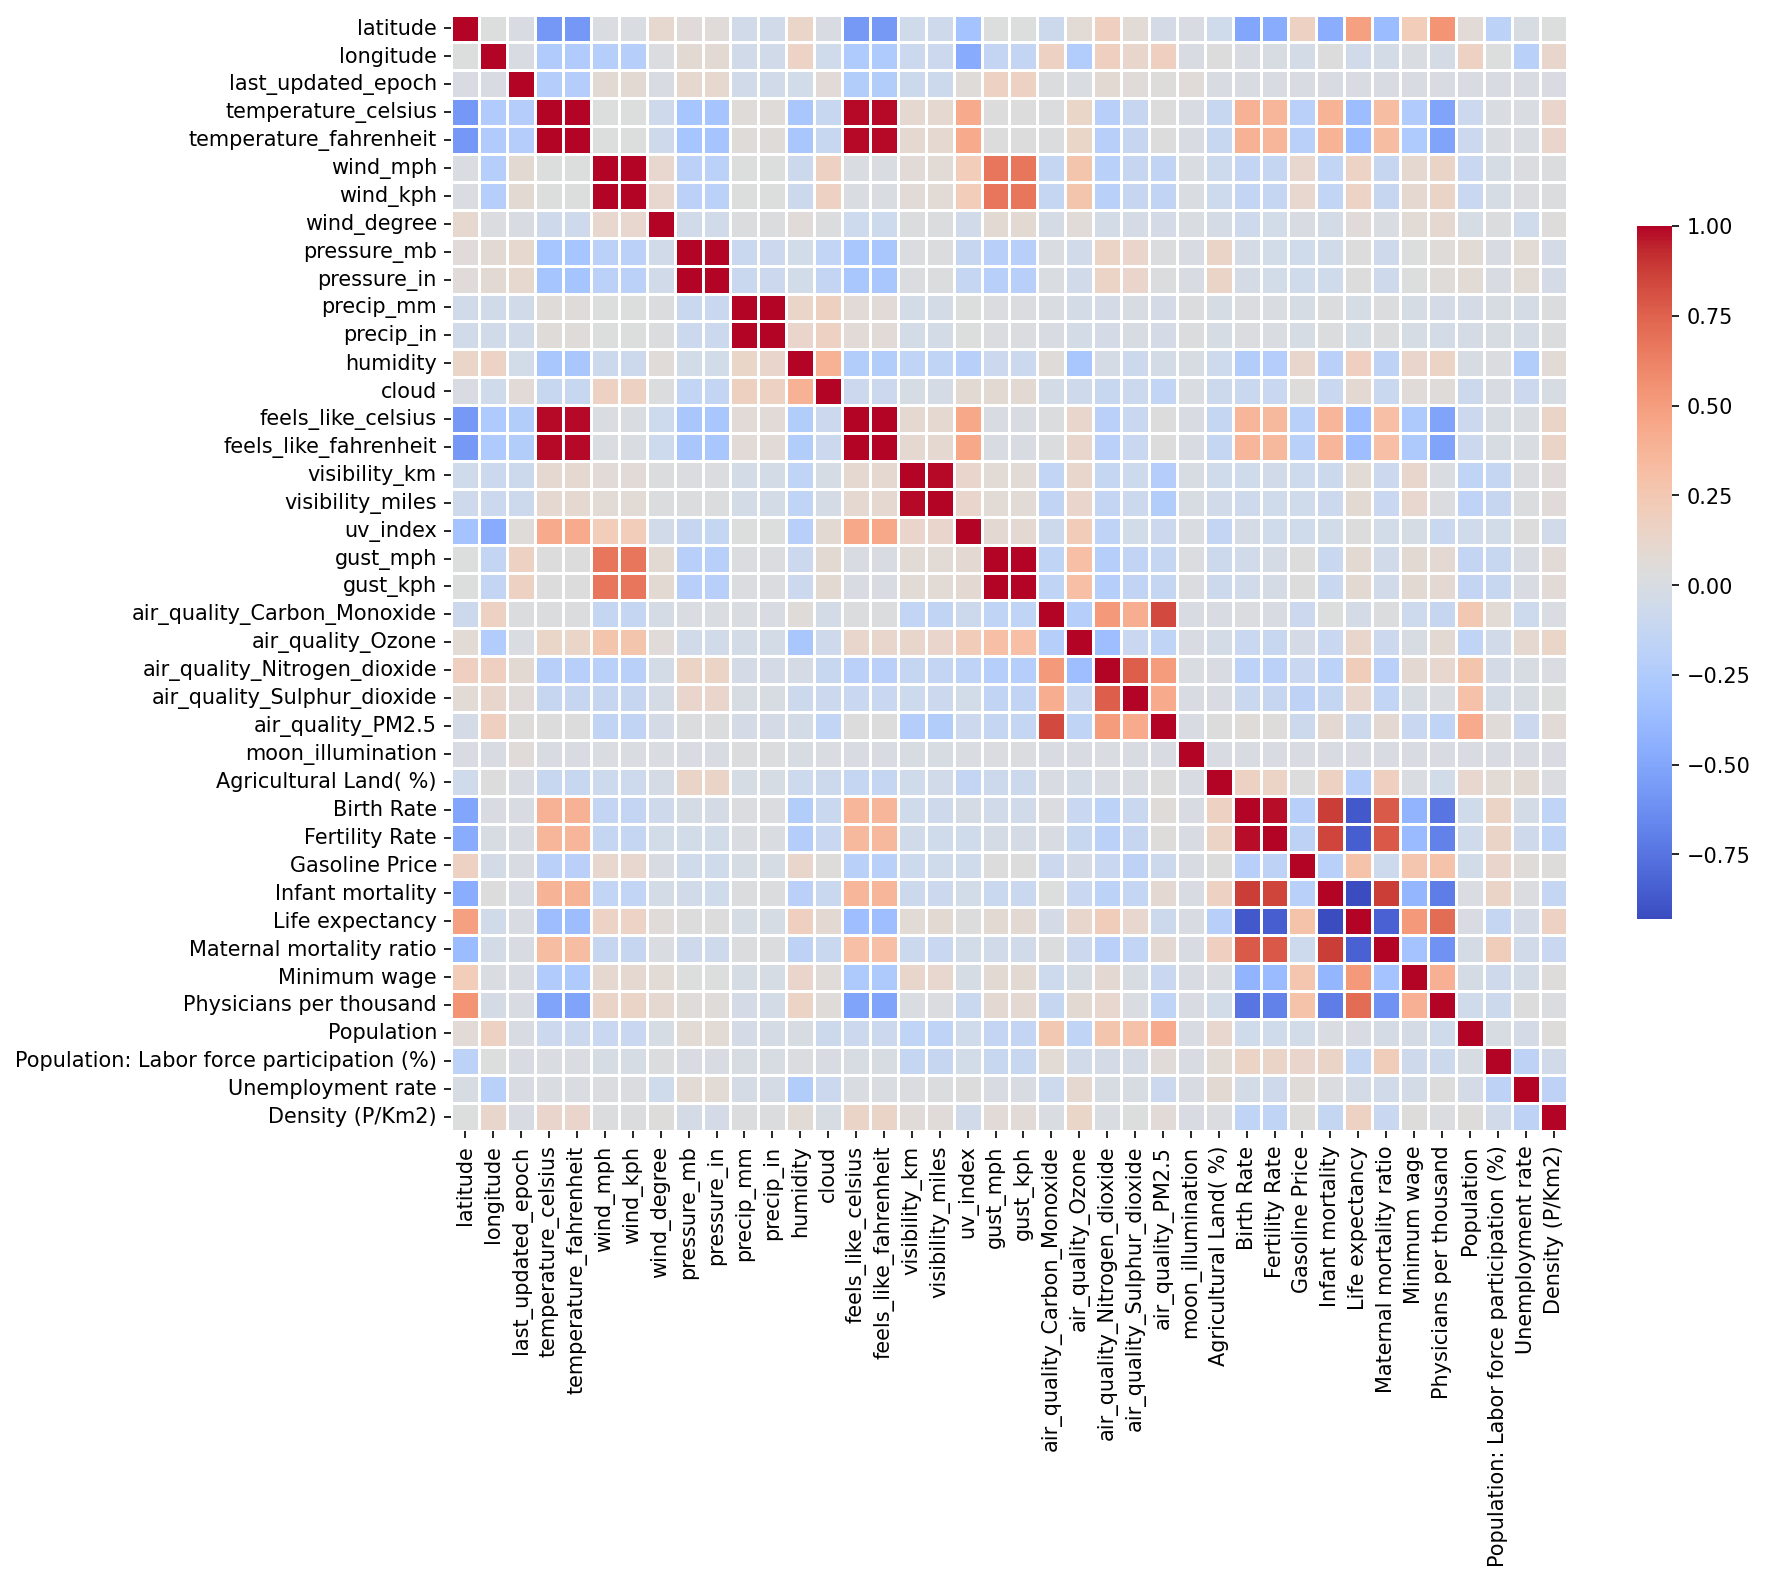

In [32]:
# Calculate the correlation matrix
correlation_matrix = merged_data.corr(numeric_only=True)

# Set up the matplotlib figure
plt.figure(figsize=(12, 12))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Show the plot
plt.show()

### Features Selection

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression, SelectKBest

# Prepare the full feature matrix and target vector
X_full = merged_data.drop(['air_quality_PM2.5'], axis=1).select_dtypes(include=[np.number])
y_full = merged_data['air_quality_PM2.5']

# Split the data into training and test sets
X_train_full, X_test_full, y_train, y_test = train_test_split(X_full, y_full, test_size=0.3, random_state=42)

# Initialize and fit StandardScaler on the training data only
scaler = StandardScaler()
X_train_full_scaled = scaler.fit_transform(X_train_full)

# Apply the scaling to the test data
X_test_full_scaled = scaler.transform(X_test_full)

# Initialize SelectKBest
k_best = SelectKBest(score_func=f_regression, k='all')

# Fit SelectKBest to the scaled training data
k_best.fit(X_train_full_scaled, y_train)

# Transform the scaled training and test sets
X_train_scaled = k_best.transform(X_train_full_scaled)
X_test_scaled = k_best.transform(X_test_full_scaled)

# Get the scores for each feature and the selected features
feature_scores = pd.DataFrame(k_best.scores_, index=X_train_full.columns, columns=['Score'])
selected_features = feature_scores.nlargest(25, 'Score').index.values  

# Display selected features
selected_features_df = pd.DataFrame(selected_features, columns=['Selected Features'])
print(selected_features_df)

                            Selected Features
0                 air_quality_Carbon_Monoxide
1                air_quality_Nitrogen_dioxide
2                 air_quality_Sulphur_dioxide
3                                  Population
4                            visibility_miles
5                               visibility_km
6                                   longitude
7                     Physicians per thousand
8                           air_quality_Ozone
9                                    wind_kph
10                                   wind_mph
11                                      cloud
12                                   gust_mph
13                                   gust_kph
14                               Minimum wage
15                   Maternal mortality ratio
16                           Infant mortality
17                          Unemployment rate
18                            Life expectancy
19                                   uv_index
20                             Gas

### Performance of each model


In [34]:
# Initialize models
regression_models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "ElasticNet Regression": ElasticNet(),
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "Gradient Boosting Regressor": GradientBoostingRegressor(),
    "Support Vector Regressor": SVR(),
    "MLP Regressor": MLPRegressor(max_iter=500)
}

# Initialize cross-validation and scoring metrics
cv = KFold(n_splits=5, random_state=42, shuffle=True)
scoring = 'neg_mean_squared_error'

# Prepare the feature matrix and target vector
X = merged_data[selected_features]
y = merged_data['air_quality_PM2.5']

# Dictionary to store each model's cross-validation results and carbon emissions
cv_results = {}
carbon_emissions = {}

for model_name, model in regression_models.items():
    # Create a pipeline that first scales the data then applies the model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    # track the Emission
    tracker = EmissionsTracker()
    tracker.start()
    
    # Perform cross-validation using the pipeline
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring=scoring)
    cv_results[model_name] = -scores  # Convert scores to positive values (since scoring was neg_mean_squared_error)
    
    emissions = tracker.stop()
    carbon_emissions[model_name] = emissions
    
    print(f"{model_name} -> MSE: {scores.mean():.4f} (+/- {scores.std():.4f}), Emissions: {emissions:.4f} kg")




[codecarbon INFO @ 16:24:29] [setup] RAM Tracking...
[codecarbon INFO @ 16:24:29] [setup] GPU Tracking...
[codecarbon INFO @ 16:24:29] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 16:24:29] [setup] CPU Tracking...
[codecarbon WARNING @ 16:24:29] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 16:24:31] We saw that you have a 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz but we don't know it. Please contact us.
[codecarbon INFO @ 16:24:31] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz
[codecarbon INFO @ 16:24:31] >>> Tracker's metadata:
[codecarbon INFO @ 16:24:31]   Platform system: Windows-10-10.0.22621-SP0
[codecarbon INFO @ 16:24:31]   Python version: 3.10.8
[codecarbon INFO @ 16:24:31]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 16:24:31]   Available RAM : 63.855 GB
[codecarbon INFO @ 16:24:31]   CPU count: 16
[codecarbon INFO @ 16:24:31]   CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GH

Linear Regression -> MSE: -1121.8320 (+/- 100.7825), Emissions: 0.0000 kg


[codecarbon WARNING @ 16:24:33] We saw that you have a 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz but we don't know it. Please contact us.
[codecarbon INFO @ 16:24:33] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz
[codecarbon INFO @ 16:24:33] >>> Tracker's metadata:
[codecarbon INFO @ 16:24:33]   Platform system: Windows-10-10.0.22621-SP0
[codecarbon INFO @ 16:24:33]   Python version: 3.10.8
[codecarbon INFO @ 16:24:33]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 16:24:33]   Available RAM : 63.855 GB
[codecarbon INFO @ 16:24:33]   CPU count: 16
[codecarbon INFO @ 16:24:33]   CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz
[codecarbon INFO @ 16:24:33]   GPU count: 1
[codecarbon INFO @ 16:24:33]   GPU model: 1 x NVIDIA GeForce RTX 3080 Laptop GPU
[codecarbon INFO @ 16:24:34] Energy consumed for RAM : 0.000001 kWh. RAM Power : 23.945546150207523 W
[codecarbon INFO @ 16:24:34] Energy consumed for all GPUs : 0.000002 kWh. Total GPU P

Ridge Regression -> MSE: -1121.8007 (+/- 100.8685), Emissions: 0.0000 kg


[codecarbon WARNING @ 16:24:35] We saw that you have a 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz but we don't know it. Please contact us.
[codecarbon INFO @ 16:24:35] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz
[codecarbon INFO @ 16:24:35] >>> Tracker's metadata:
[codecarbon INFO @ 16:24:35]   Platform system: Windows-10-10.0.22621-SP0
[codecarbon INFO @ 16:24:35]   Python version: 3.10.8
[codecarbon INFO @ 16:24:35]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 16:24:35]   Available RAM : 63.855 GB
[codecarbon INFO @ 16:24:35]   CPU count: 16
[codecarbon INFO @ 16:24:35]   CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz
[codecarbon INFO @ 16:24:35]   GPU count: 1
[codecarbon INFO @ 16:24:35]   GPU model: 1 x NVIDIA GeForce RTX 3080 Laptop GPU
[codecarbon INFO @ 16:24:36] Energy consumed for RAM : 0.000001 kWh. RAM Power : 23.945546150207523 W
[codecarbon INFO @ 16:24:36] Energy consumed for all GPUs : 0.000002 kWh. Total GPU P

Lasso Regression -> MSE: -1141.2534 (+/- 105.8219), Emissions: 0.0000 kg


[codecarbon WARNING @ 16:24:37] We saw that you have a 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz but we don't know it. Please contact us.
[codecarbon INFO @ 16:24:37] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz
[codecarbon INFO @ 16:24:37] >>> Tracker's metadata:
[codecarbon INFO @ 16:24:37]   Platform system: Windows-10-10.0.22621-SP0
[codecarbon INFO @ 16:24:37]   Python version: 3.10.8
[codecarbon INFO @ 16:24:37]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 16:24:37]   Available RAM : 63.855 GB
[codecarbon INFO @ 16:24:37]   CPU count: 16
[codecarbon INFO @ 16:24:37]   CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz
[codecarbon INFO @ 16:24:37]   GPU count: 1
[codecarbon INFO @ 16:24:37]   GPU model: 1 x NVIDIA GeForce RTX 3080 Laptop GPU
[codecarbon INFO @ 16:24:38] Energy consumed for RAM : 0.000001 kWh. RAM Power : 23.945546150207523 W
[codecarbon INFO @ 16:24:38] Energy consumed for all GPUs : 0.000003 kWh. Total GPU P

ElasticNet Regression -> MSE: -1473.8946 (+/- 129.9016), Emissions: 0.0000 kg


[codecarbon WARNING @ 16:24:39] We saw that you have a 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz but we don't know it. Please contact us.
[codecarbon INFO @ 16:24:39] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz
[codecarbon INFO @ 16:24:39] >>> Tracker's metadata:
[codecarbon INFO @ 16:24:39]   Platform system: Windows-10-10.0.22621-SP0
[codecarbon INFO @ 16:24:39]   Python version: 3.10.8
[codecarbon INFO @ 16:24:39]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 16:24:39]   Available RAM : 63.855 GB
[codecarbon INFO @ 16:24:39]   CPU count: 16
[codecarbon INFO @ 16:24:39]   CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz
[codecarbon INFO @ 16:24:39]   GPU count: 1
[codecarbon INFO @ 16:24:39]   GPU model: 1 x NVIDIA GeForce RTX 3080 Laptop GPU
[codecarbon INFO @ 16:24:42] Energy consumed for RAM : 0.000018 kWh. RAM Power : 23.945546150207523 W
[codecarbon INFO @ 16:24:42] Energy consumed for all GPUs : 0.000015 kWh. Total GPU P

Decision Tree Regressor -> MSE: -805.2892 (+/- 161.2794), Emissions: 0.0000 kg


[codecarbon WARNING @ 16:24:44] We saw that you have a 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz but we don't know it. Please contact us.
[codecarbon INFO @ 16:24:44] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz
[codecarbon INFO @ 16:24:44] >>> Tracker's metadata:
[codecarbon INFO @ 16:24:44]   Platform system: Windows-10-10.0.22621-SP0
[codecarbon INFO @ 16:24:44]   Python version: 3.10.8
[codecarbon INFO @ 16:24:44]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 16:24:44]   Available RAM : 63.855 GB
[codecarbon INFO @ 16:24:44]   CPU count: 16
[codecarbon INFO @ 16:24:44]   CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz
[codecarbon INFO @ 16:24:44]   GPU count: 1
[codecarbon INFO @ 16:24:44]   GPU model: 1 x NVIDIA GeForce RTX 3080 Laptop GPU
[codecarbon INFO @ 16:24:59] Energy consumed for RAM : 0.000100 kWh. RAM Power : 23.945546150207523 W
[codecarbon INFO @ 16:24:59] Energy consumed for all GPUs : 0.000072 kWh. Total GPU P

Random Forest Regressor -> MSE: -420.7779 (+/- 73.8405), Emissions: 0.0018 kg


[codecarbon WARNING @ 16:28:20] We saw that you have a 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz but we don't know it. Please contact us.
[codecarbon INFO @ 16:28:20] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz
[codecarbon INFO @ 16:28:20] >>> Tracker's metadata:
[codecarbon INFO @ 16:28:20]   Platform system: Windows-10-10.0.22621-SP0
[codecarbon INFO @ 16:28:20]   Python version: 3.10.8
[codecarbon INFO @ 16:28:20]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 16:28:20]   Available RAM : 63.855 GB
[codecarbon INFO @ 16:28:20]   CPU count: 16
[codecarbon INFO @ 16:28:20]   CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz
[codecarbon INFO @ 16:28:20]   GPU count: 1
[codecarbon INFO @ 16:28:20]   GPU model: 1 x NVIDIA GeForce RTX 3080 Laptop GPU
[codecarbon INFO @ 16:28:35] Energy consumed for RAM : 0.000100 kWh. RAM Power : 23.945546150207523 W
[codecarbon INFO @ 16:28:35] Energy consumed for all GPUs : 0.000065 kWh. Total GPU P

Gradient Boosting Regressor -> MSE: -584.6144 (+/- 70.5997), Emissions: 0.0002 kg


[codecarbon WARNING @ 16:28:42] We saw that you have a 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz but we don't know it. Please contact us.
[codecarbon INFO @ 16:28:42] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz
[codecarbon INFO @ 16:28:42] >>> Tracker's metadata:
[codecarbon INFO @ 16:28:42]   Platform system: Windows-10-10.0.22621-SP0
[codecarbon INFO @ 16:28:42]   Python version: 3.10.8
[codecarbon INFO @ 16:28:42]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 16:28:42]   Available RAM : 63.855 GB
[codecarbon INFO @ 16:28:42]   CPU count: 16
[codecarbon INFO @ 16:28:42]   CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz
[codecarbon INFO @ 16:28:42]   GPU count: 1
[codecarbon INFO @ 16:28:42]   GPU model: 1 x NVIDIA GeForce RTX 3080 Laptop GPU
[codecarbon INFO @ 16:28:58] Energy consumed for RAM : 0.000100 kWh. RAM Power : 23.945546150207523 W
[codecarbon INFO @ 16:28:58] Energy consumed for all GPUs : 0.000069 kWh. Total GPU P

Support Vector Regressor -> MSE: -3801.8205 (+/- 751.6205), Emissions: 0.0010 kg


[codecarbon WARNING @ 16:30:45] We saw that you have a 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz but we don't know it. Please contact us.
[codecarbon INFO @ 16:30:45] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz
[codecarbon INFO @ 16:30:45] >>> Tracker's metadata:
[codecarbon INFO @ 16:30:45]   Platform system: Windows-10-10.0.22621-SP0
[codecarbon INFO @ 16:30:45]   Python version: 3.10.8
[codecarbon INFO @ 16:30:45]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 16:30:45]   Available RAM : 63.855 GB
[codecarbon INFO @ 16:30:45]   CPU count: 16
[codecarbon INFO @ 16:30:45]   CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz
[codecarbon INFO @ 16:30:45]   GPU count: 1
[codecarbon INFO @ 16:30:45]   GPU model: 1 x NVIDIA GeForce RTX 3080 Laptop GPU
[codecarbon INFO @ 16:31:00] Energy consumed for RAM : 0.000100 kWh. RAM Power : 23.945546150207523 W
[codecarbon INFO @ 16:31:00] Energy consumed for all GPUs : 0.000069 kWh. Total GPU P

MLP Regressor -> MSE: -448.0870 (+/- 54.0302), Emissions: 0.0009 kg


#### MSE and Carbon Emission plot


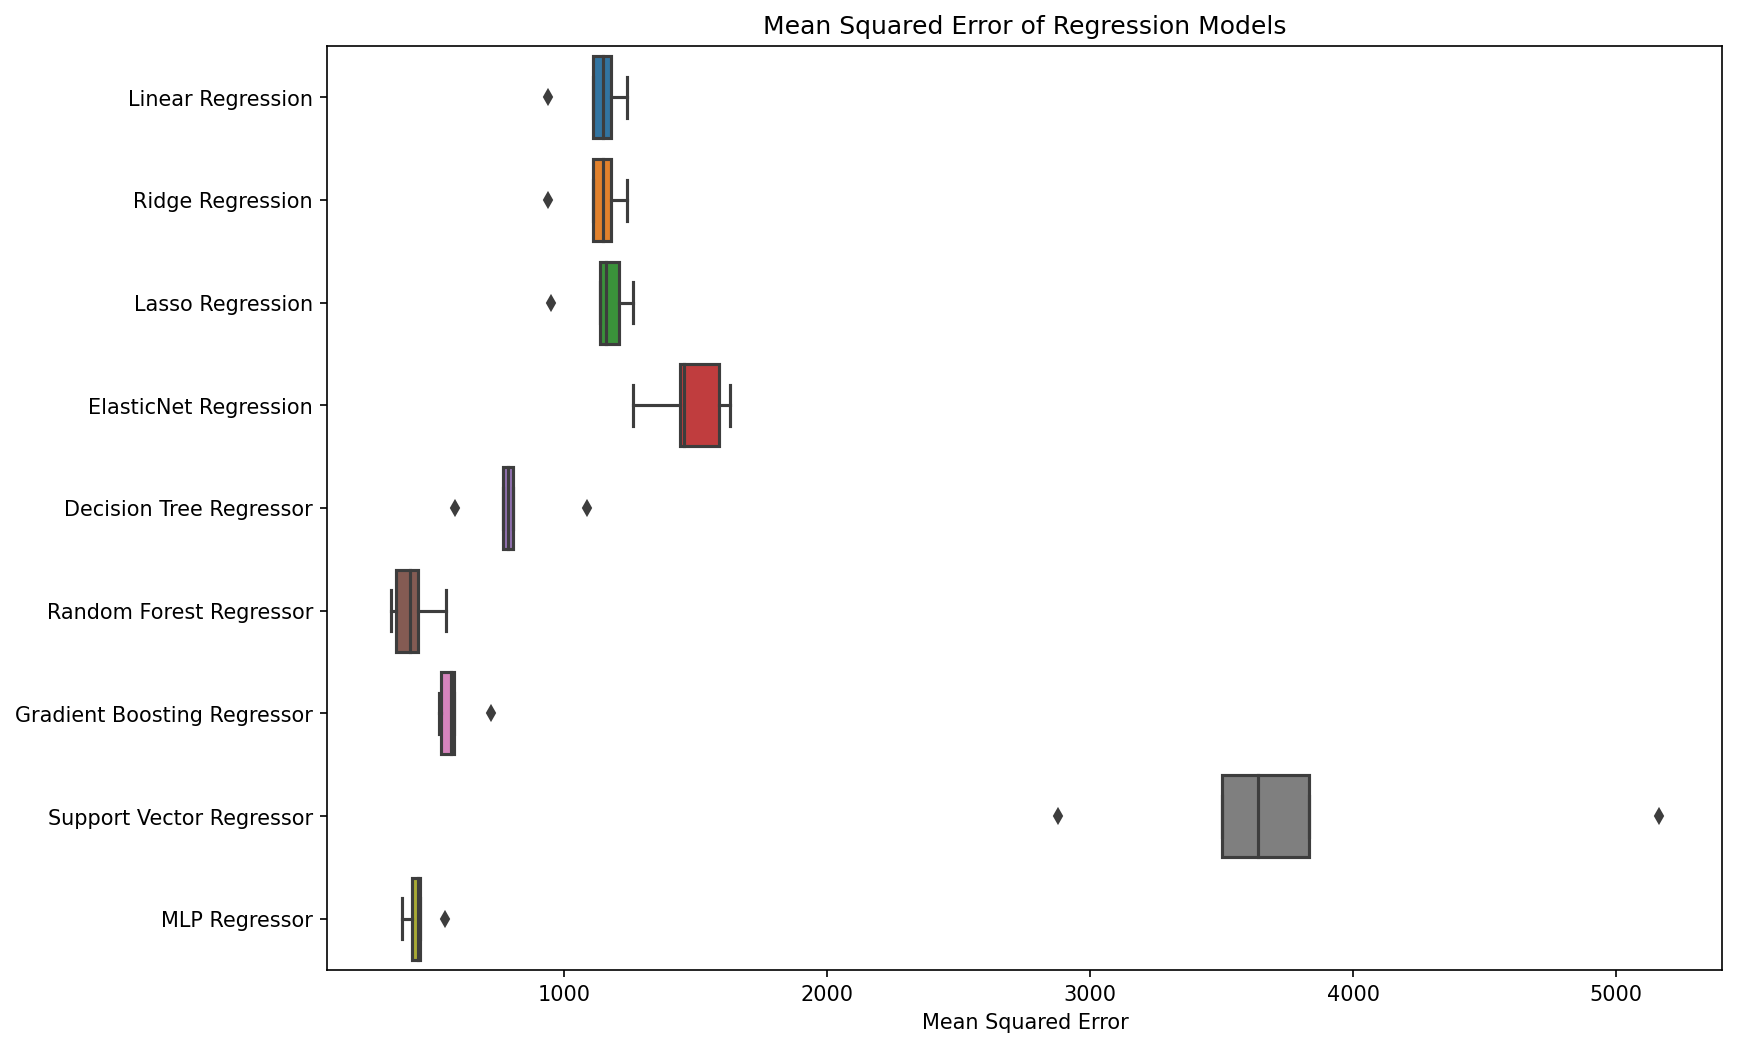

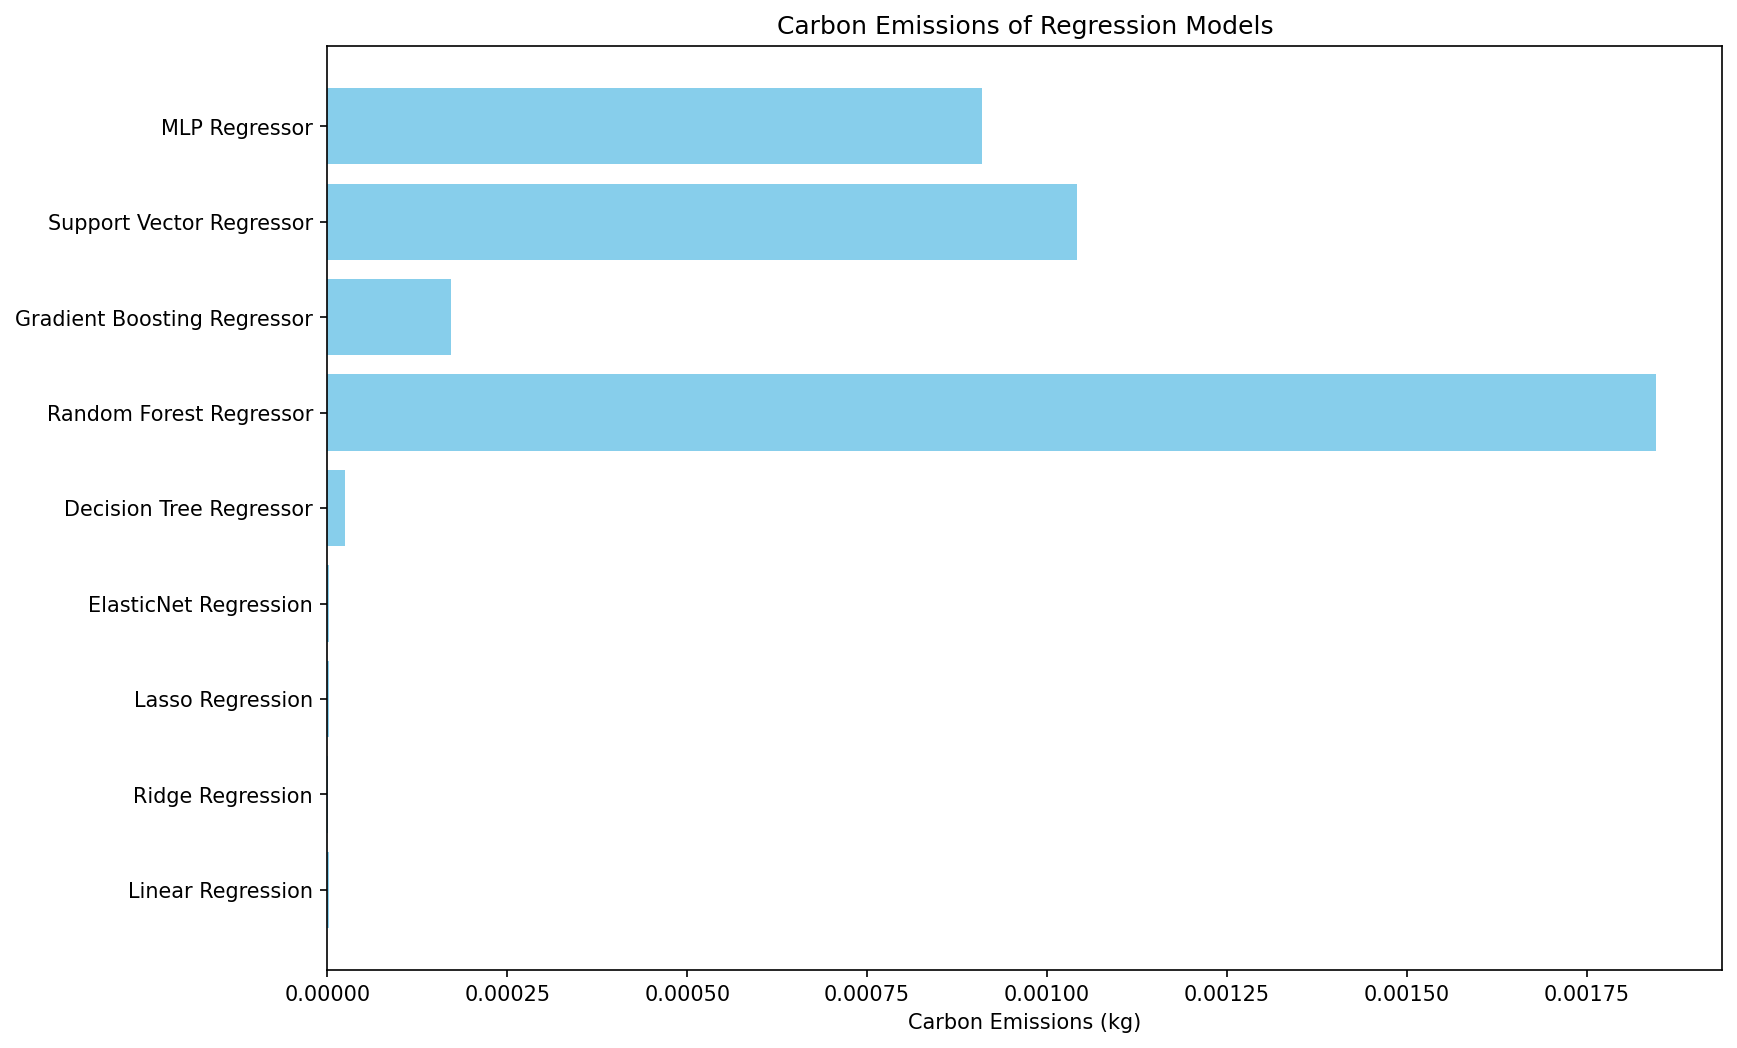

In [35]:
# Box plot for the Mean Squared Error of each regressor (based on the cross-validation folds)
plt.figure(figsize=(12, 8))
sns.boxplot(data=pd.DataFrame(cv_results), orient="h")
plt.title('Mean Squared Error of Regression Models')
plt.xlabel('Mean Squared Error')
plt.show()

# Bar plot for the carbon emissions of each regressor
plt.figure(figsize=(12, 8))
plt.barh(list(carbon_emissions.keys()), list(carbon_emissions.values()), color='skyblue')
plt.title('Carbon Emissions of Regression Models')
plt.xlabel('Carbon Emissions (kg)')
plt.show()



In [36]:
# Convert MSE scores and carbon emissions into a DataFrame
results_df = pd.DataFrame({
    'Model': cv_results.keys(),
    'MSE Mean': [scores.mean() for scores in cv_results.values()],
    'MSE Std': [scores.std() for scores in cv_results.values()],
    'Carbon Emissions (kg)': [emissions for emissions in carbon_emissions.values()]
})

# Display the DataFrame
results_df.sort_values(by="MSE Mean",ascending=True)

,Model,MSE Mean,MSE Std,Carbon Emissions (kg)
5,Random Forest Regressor,420.777888,73.840508,0.001846
8,MLP Regressor,448.086988,54.030233,0.000909
6,Gradient Boosting Regressor,584.614433,70.599741,0.000172
4,Decision Tree Regressor,805.289246,161.279447,0.000024
1,Ridge Regression,1121.800739,100.868524,0.000001
0,Linear Regression,1121.832039,100.782458,0.000002
2,Lasso Regression,1141.253410,105.821898,0.000002
3,ElasticNet Regression,1473.894649,129.901579,0.000002
7,Support Vector Regressor,3801.820476,751.620532,0.001042


Based on the result we will select these models as base models:

**Random Forest Regressor**: Shows a good balance with a relatively low MSE and acceptable carbon emissions. It stands out as a strong candidate due to its performance, despite slightly higher emissions compared to some other models.

**MLP Regressor**: Although the MSE is somewhat higher than the Random Forest, the carbon emissions are quite low, making it an attractive option for balancing performance and environmental considerations.

**Gradient Boosting Regressor**: Offers a reasonable compromise between MSE and carbon emissions. While its MSE is higher than the Random Forest and MLP Regressors, its carbon emissions are significantly lower, indicating efficient computational performance.

**Decision Tree Regressor**: While it has a higher MSE compared to the top three, the carbon emissions are extremely low, which might make it a valuable addition to an ensemble, especially for reducing the overall environmental impact.


### Feature Importance based on random forest

In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from codecarbon import EmissionsTracker

# Prepare the feature matrix and target vector
X = merged_data[selected_features] 
y = merged_data['air_quality_PM2.5']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize StandardScaler
scaler = StandardScaler()

# Scale the training and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Initialize the emissions tracker
tracker = EmissionsTracker()

# Start tracking carbon emissions
tracker.start()

# Train the RandomForestRegressor on the scaled training data
rf_regressor.fit(X_train_scaled, y_train)

# Predict PM2.5 levels on the scaled test set
y_pred = rf_regressor.predict(X_test_scaled)

# Stop tracking and report the emissions
emissions = tracker.stop()
print(f"Estimated carbon emissions for RandomForest training: {emissions} kg")

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2): {r2}')

# Get feature importance from RandomForestRegressor
feature_importances = rf_regressor.feature_importances_

# Display the feature importances
features_df = pd.DataFrame({'Feature': selected_features, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)
print(features_df)


[codecarbon INFO @ 16:32:32] [setup] RAM Tracking...
[codecarbon INFO @ 16:32:32] [setup] GPU Tracking...
[codecarbon INFO @ 16:32:32] Tracking Nvidia GPU via pynvml


[codecarbon INFO @ 16:32:32] [setup] CPU Tracking...
[codecarbon WARNING @ 16:32:32] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 16:32:33] We saw that you have a 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz but we don't know it. Please contact us.
[codecarbon INFO @ 16:32:33] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz
[codecarbon INFO @ 16:32:33] >>> Tracker's metadata:
[codecarbon INFO @ 16:32:33]   Platform system: Windows-10-10.0.22621-SP0
[codecarbon INFO @ 16:32:33]   Python version: 3.10.8
[codecarbon INFO @ 16:32:33]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 16:32:33]   Available RAM : 63.855 GB
[codecarbon INFO @ 16:32:33]   CPU count: 16
[codecarbon INFO @ 16:32:33]   CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz
[codecarbon INFO @ 16:32:33]   GPU count: 1
[codecarbon INFO @ 16:32:33]   GPU model: 1 x NVIDIA GeForce RTX 3080 Laptop GPU
[codecarbon INFO @ 16:32:49] Energy con

Estimated carbon emissions for RandomForest training: 0.00031371562281857135 kg
Mean Squared Error (MSE): 402.8078267247468
R-squared (R2): 0.9148916409049233
                                      Feature  Importance
0                 air_quality_Carbon_Monoxide    0.728253
3                                  Population    0.062332
21                            Density (P/Km2)    0.022366
1                air_quality_Nitrogen_dioxide    0.020656
5                               visibility_km    0.017366
11                                      cloud    0.016968
2                 air_quality_Sulphur_dioxide    0.016580
8                           air_quality_Ozone    0.016259
20                             Gasoline Price    0.013735
24                             Fertility Rate    0.009382
17                          Unemployment rate    0.009127
13                                   gust_kph    0.008110
15                   Maternal mortality ratio    0.007820
6                            

#### Feature Importance Plot

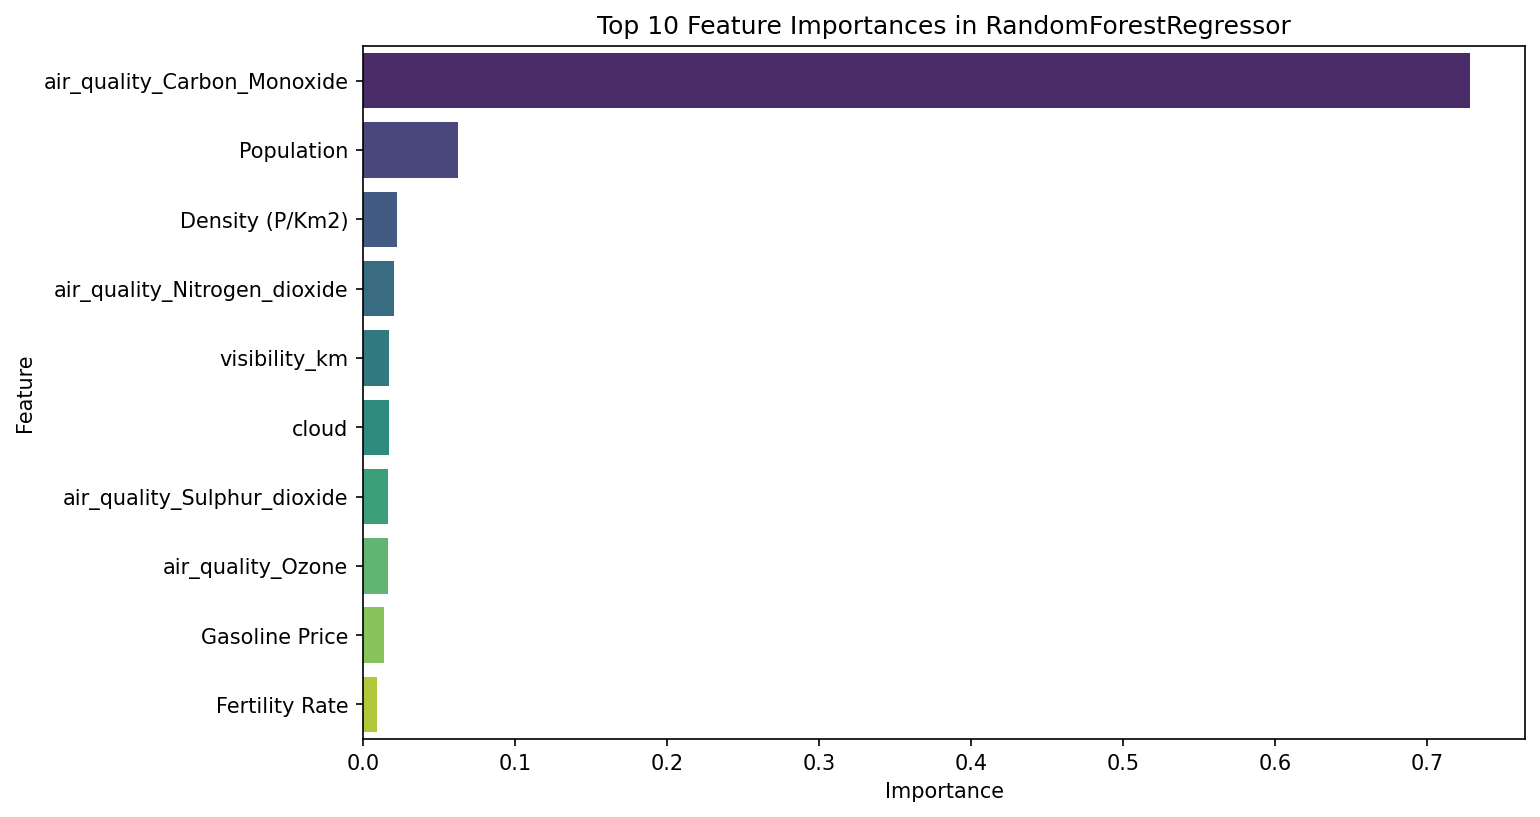

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select the top 10 features
top_features_df = features_df.head(10)

# Create a bar plot for the top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_features_df, palette='viridis')

plt.title('Top 10 Feature Importances in RandomForestRegressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### Stacked Regressor

In [39]:
from sklearn.metrics import mean_squared_error, r2_score

Here we will choose ridge regressor as meta regressor

In [40]:
from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Define the base regressors
estimators = [
    ('random_forest', make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, random_state=42))),
    ('mlp', make_pipeline(StandardScaler(), MLPRegressor(max_iter=500, random_state=42))),
    ('gradient_boosting', make_pipeline(StandardScaler(), GradientBoostingRegressor(random_state=42))),
    ('decision_tree', make_pipeline(StandardScaler(), DecisionTreeRegressor(random_state=42)))
]

# Initialize the Stacking Regressor with Ridge as a meta regressor
stack_reg = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge()
)

# Prepare the feature matrix and target vector
X = merged_data[selected_features]
y = merged_data['air_quality_PM2.5']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the emissions tracker
tracker = EmissionsTracker()

# Start tracking carbon emissions
tracker.start()

# Fit the stacking regressor on the training data
stack_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = stack_reg.predict(X_test)

# Stop tracking and report the emissions
emissions = tracker.stop()
print(f"Estimated carbon emissions for model training: {emissions} kg")



[codecarbon INFO @ 16:33:10] [setup] RAM Tracking...
[codecarbon INFO @ 16:33:10] [setup] GPU Tracking...
[codecarbon INFO @ 16:33:10] Tracking Nvidia GPU via pynvml


[codecarbon INFO @ 16:33:10] [setup] CPU Tracking...
[codecarbon WARNING @ 16:33:10] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 16:33:12] We saw that you have a 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz but we don't know it. Please contact us.
[codecarbon INFO @ 16:33:12] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz
[codecarbon INFO @ 16:33:12] >>> Tracker's metadata:
[codecarbon INFO @ 16:33:12]   Platform system: Windows-10-10.0.22621-SP0
[codecarbon INFO @ 16:33:12]   Python version: 3.10.8
[codecarbon INFO @ 16:33:12]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 16:33:12]   Available RAM : 63.855 GB
[codecarbon INFO @ 16:33:12]   CPU count: 16
[codecarbon INFO @ 16:33:12]   CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz
[codecarbon INFO @ 16:33:12]   GPU count: 1
[codecarbon INFO @ 16:33:12]   GPU model: 1 x NVIDIA GeForce RTX 3080 Laptop GPU
[codecarbon INFO @ 16:33:27] Energy con

Estimated carbon emissions for model training: 0.0026976429672149415 kg


In [41]:
# Evaluate the model
stacked_mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {stacked_mse}')
print(f'R-squared (R2): {r2}')


Mean Squared Error (MSE): 377.07630944624447
R-squared (R2): 0.9203283952758765


We can see that the stacked model has better performance based on the results.

#### Comparison Between Stacked Regressor and base models

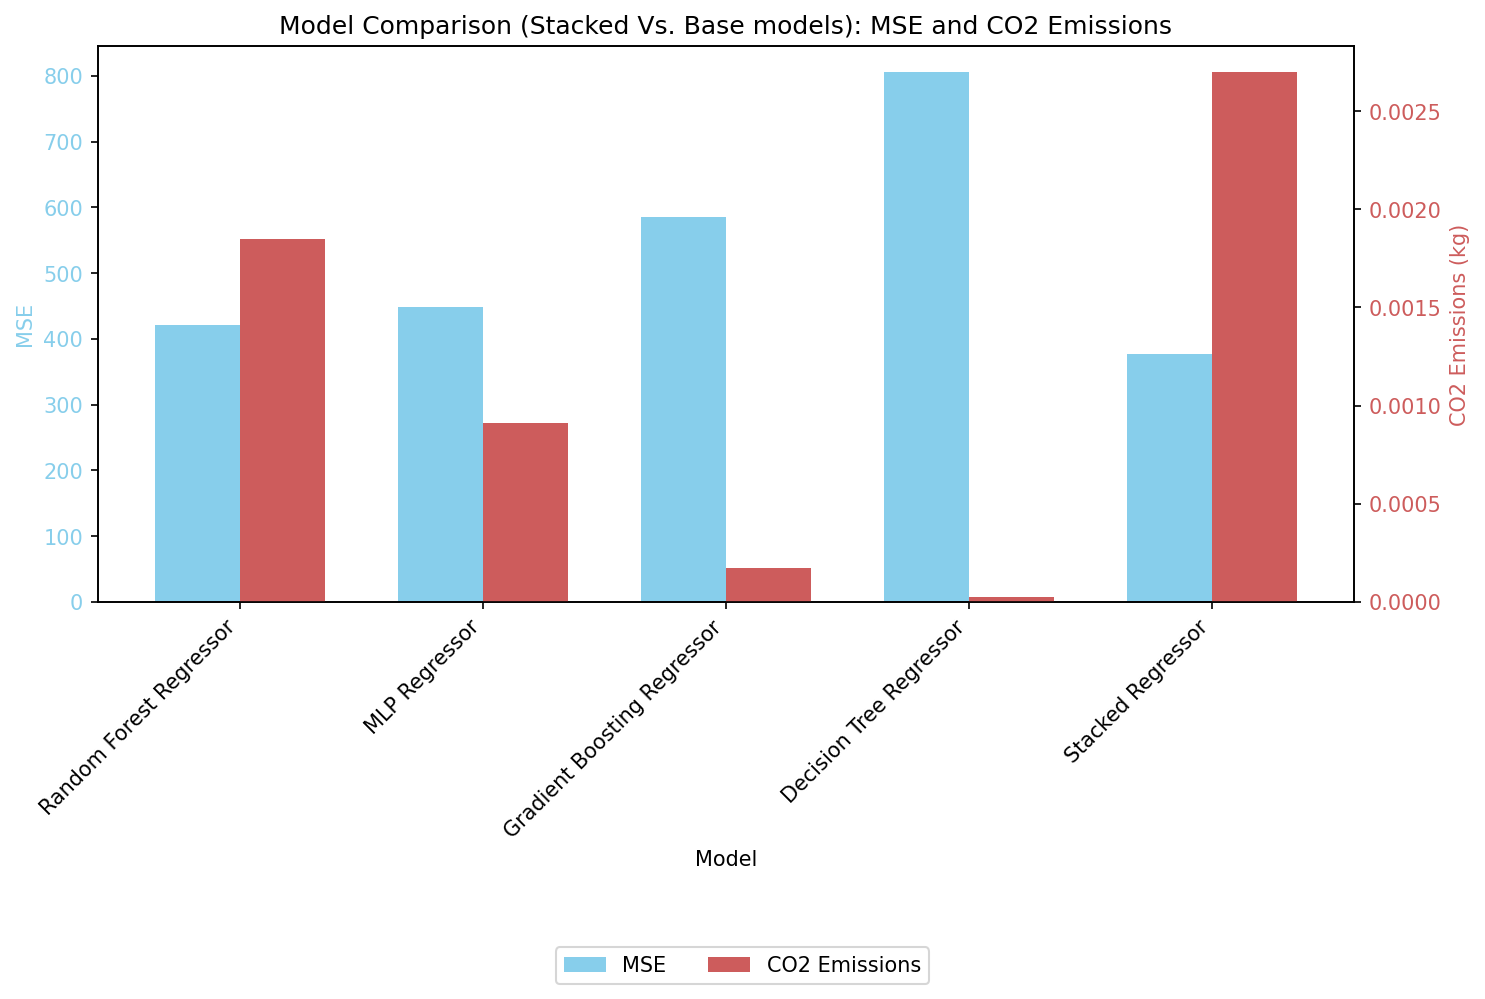

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Selected model names including the stacked regressor
selected_models = ['Random Forest Regressor', 'MLP Regressor', 'Gradient Boosting Regressor', 'Decision Tree Regressor', 'Stacked Regressor']

# MSE values for the selected models, with the stacked regressor's MSE added at the end
selected_mse_values = [cv_results[model].mean() for model in selected_models[:-1]] + [stacked_mse]

# CO2 emissions for the selected models, with the stacked regressor's emissions added at the end
selected_emissions_values = [carbon_emissions[model] for model in selected_models[:-1]] + [emissions]

# Setting up the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar locations for the selected models
ind = np.arange(len(selected_models))
width = 0.35  # the width of the bars

# Plot MSE values for the selected models
mse_bars = ax1.bar(ind - width/2, selected_mse_values, width, color='SkyBlue', label='MSE')

# Set up the first y-axis for MSE
ax1.set_xlabel('Model')
ax1.set_ylabel('MSE', color='SkyBlue')
ax1.set_title('Model Comparison (Stacked Vs. Base models): MSE and CO2 Emissions')
ax1.set_xticks(ind)
ax1.set_xticklabels(selected_models, rotation=45, ha='right')
ax1.tick_params(axis='y', labelcolor='SkyBlue')

# Set up the second y-axis for CO2 emissions
ax2 = ax1.twinx()
emissions_bars = ax2.bar(ind + width/2, selected_emissions_values, width, color='IndianRed', label='CO2 Emissions')
ax2.set_ylabel('CO2 Emissions (kg)', color='IndianRed')
ax2.tick_params(axis='y', labelcolor='IndianRed')

# Add legend
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

fig.tight_layout()
plt.show()


We can see that the stacked regressor has a relatively better performance of MSE results with acceptable CO2 emissions.

### Save and Load the Model

In [43]:
import pickle

# Save the trained stacking regressor to a .pkl file
with open('stacking_regressor_model.pkl', 'wb') as file:
    pickle.dump(stack_reg, file)

print("Stacking regressor model saved as 'stacking_regressor_model.pkl'")


Stacking regressor model saved as 'stacking_regressor_model.pkl'


In [44]:
import pickle
from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

In [45]:
# Load the trained stacking regressor from the .pkl file
with open('stacking_regressor_model.pkl', 'rb') as file:
    loaded_stack_reg = pickle.load(file)

print("Stacking regressor model loaded successfully")


Stacking regressor model loaded successfully


### Prediction Plot

Loaded Model - Mean Squared Error (MSE): 377.07630944624447
Loaded Model - R-squared (R2): 0.9203283952758765


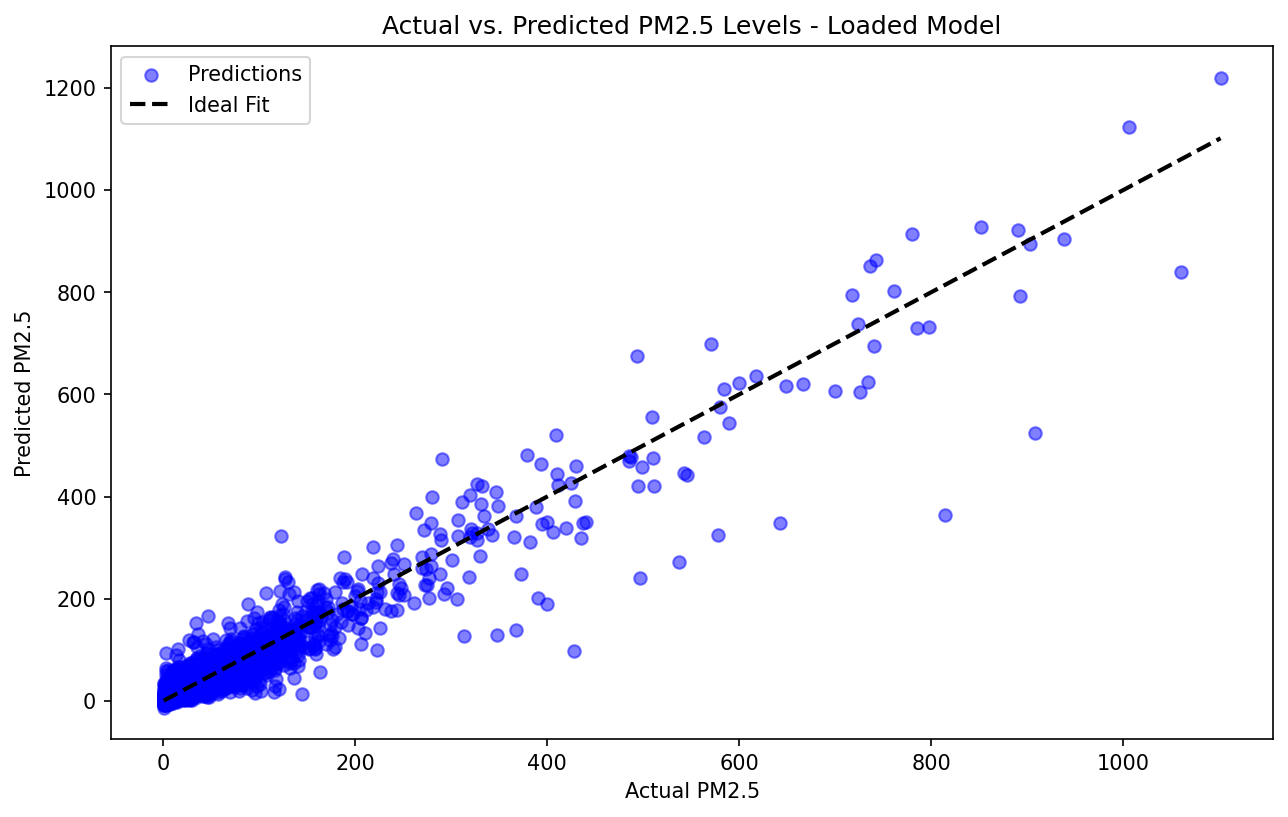

In [46]:
import matplotlib.pyplot as plt

# Use the loaded model to make predictions on the test set
y_pred_loaded = loaded_stack_reg.predict(X_test)

# Calculate performance metrics
mse_loaded = mean_squared_error(y_test, y_pred_loaded)
r2_loaded = r2_score(y_test, y_pred_loaded)
print(f'Loaded Model - Mean Squared Error (MSE): {mse_loaded}')
print(f'Loaded Model - R-squared (R2): {r2_loaded}')

# Scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_loaded, color='blue', label='Predictions', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal Fit')
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')
plt.title('Actual vs. Predicted PM2.5 Levels - Loaded Model')
plt.legend()
plt.show()
